# Drive cycle characterisation for real world fuel economy prediction

Link to the paper: https://www.sae.org/publications/technical-papers/content/2018-01-0644/

This notebook is based on the SAE technical paper by H. Cho and V. D'urbal.

The paper aims to establish metrics for real world drive cycles that can be predictors of fuel (energy) consumption.
Building on those metrics it proposes a methodology to compare drive cycles based on their aggressiveness or city/highway driving characteristics from fuel consumption point of view.

Central idea is to take the contributors of energy consumption and express them as a function of vehicle speed <br/>

$$ \frac{V_{fuel}}{d} \rho_{fuel} Q_{LHV} \eta_{PT} = \frac{E_{PT}}{d} = \frac{E_{rolling} + E_{aero} + E_{+kinetic}}{d} \hspace{1cm} (1) $$

$$ E_{rolling} = \int{F_{rolling}.vdt} = c_{rolling}mg \int{v dt} = c_{rolling} mg.d \hspace{1cm} (2) $$

$$ E_{aero} = \int{F_{aero}.vdt} = \frac{1}{2} \rho_{air}c_{d}A\int{v^{3} dt} = \frac{1}{2} \rho_{air}c_{d}A \Sigma (v^{3}\Delta t) \hspace{0.5cm} (3) $$

$$ E_{+kinetic} = \frac{1}{2}m \Sigma \Delta _{+} (v^{2})             \hspace{1cm} (4) $$

$$ where, \Delta _{+} (v^{2}) = \begin{cases} \Delta (v^{2}), \Delta (v^{2}) >=0 \\    
0, \Delta (v^{2}) < 0 \\
\end{cases}$$  <br/>


$$ \frac{E_{PT}}{d} = c_{rolling}mg + \frac{1}{2} \rho_{air}c_{d}A \Sigma (v^{3}\Delta t) + \frac{1}{2}m \Sigma \Delta _{+} (v^{2}) $$
 
<br/> 
**RCS**: Relative cubic speed <br/>
**PKE**: Positive kinetic energy 

$$ RCS = \frac{\Sigma(v^{3} \Delta t)}{d} \hspace{1cm} PKE = \frac{\Delta _{+}(v^{2})}{d} $$


Now, based on these 2 metrics the analysis is built to assess the aggressiveness and city/motorway charateristics of drive cycles


In [1]:
import os
os.system('pip install -U -r requirements.txt')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF

import math
from sklearn.decomposition import PCA


### Generate dummy data of RCS and PKE

**PKE**: Positive kinetic energy, which is normally distributed  
**RCS**: Relative cubic speed, which is lognormally distributed 

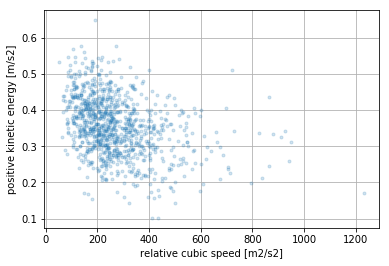

In [2]:
no_cycles = 1000
np.random.seed(42)

mu_pke, std_pke = 0.35, 0.08 # Visually checking histogram in report

mu_log_rcs, std_log_rcs = 5.5, 0.5 # Visually checking histogram in report

covariance = -0.4*std_pke*std_log_rcs # covariance of log_rcs and pke
mu         = [mu_log_rcs, mu_pke]
cov        = [[std_log_rcs**2, covariance], [covariance, std_pke**2]]

log_rcs, pke  = np.random.multivariate_normal(mu, cov, no_cycles).T
rcs           = np.exp(log_rcs)

mu_data  = [np.mean(log_rcs), np.mean(pke)]
cov_data = np.cov([log_rcs, pke])

plt.plot(rcs, pke, '.', alpha=0.2)
plt.xlabel('relative cubic speed [m2/s2]')
plt.ylabel('positive kinetic energy [m/s2]')
plt.grid()


In [4]:
def calculate_rcs_pke(speed_mps, time_step=1):
    cycle_distance = np.trapz(speed_mps, np.arange(0, len(speed_mps), time_step))
    rcs            = np.sum(speed_mps**3)*time_step/cycle_distance
    pke            = np.sum(np.diff(speed_mps**2)*(np.diff(speed_mps**2)>0))*time_step/cycle_distance
    
    return rcs, pke

def mah_distance(log_rcs_value, pke_value, mu=mu_data, cov=cov_data):
    rcs_pke_vector = np.array([log_rcs_value, pke_value]) 
    mah_dist = np.sqrt(np.transpose(rcs_pke_vector - np.array(mu))@np.linalg.inv(cov)@(rcs_pke_vector - np.array(mu)))
    return mah_dist

def normquantplot(dataVect, title='data'):
    """ NORMQUANTPLOT plot the normal quantile plot to check if the data is approximately normal """
    dataVect = np.sort(dataVect)
    mm       = np.mean(dataVect)
    dev      = np.std(dataVect)
    per      = (np.arange(len(dataVect))+1)/len(dataVect)
    zvals    = norm.ppf(per);
    plt.plot(dataVect, zvals, '+', label=title)
    plt.plot([mm-2*dev, mm+2*dev], [-2,2],'--', label='Approximate Normal line')
    plt.title('Normal Quantile plot of '+ title)
    plt.ylabel('Normal Score')
    plt.xlabel(title)
    plt.grid()
    plt.legend()
    plt.show()
    

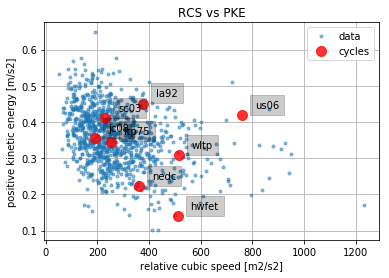

In [5]:
cycles_data        = np.array([[515, 0.308], [362, 0.223], [253, 0.346], [511, 0.140],
                    [761, 0.418], [230, 0.410], [377, 0.451], [191, 0.356]])
cycle_names        = ['wltp', 'nedc', 'ftp75', 'hwfet', 'us06', 'sc03', 'la92', 'jc08']

plt.plot(rcs, pke, '.', alpha=0.5, label='data')
plt.plot(cycles_data[:,0], cycles_data[:,1], 'or', alpha=0.8, ms=10, label='cycles')
for i, cycle in enumerate(cycle_names):
    plt.text(cycles_data[i][0]+50, cycles_data[i][1]+0.02, cycle,
            bbox={'facecolor': 'black', 'alpha': 0.2, 'pad': 5})

plt.title('RCS vs PKE')
plt.xlabel('relative cubic speed [m2/s2]')
plt.ylabel('positive kinetic energy [m/s2]')
plt.grid()
plt.legend()
plt.show()

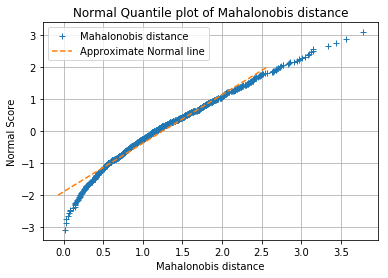

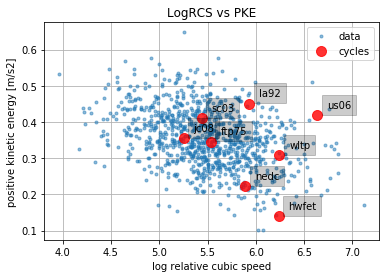

In [6]:
# Checking the data is approximately Chi2 distributed

d = [mah_distance(lrcs_i, pke_i, mu=mu_data, cov=cov_data) for lrcs_i, pke_i in zip(log_rcs, pke)]

normquantplot(d, 'Mahalonobis distance')

plt.plot(log_rcs, pke, '.', alpha=0.5, label='data')
plt.plot(np.log(cycles_data[:,0]), cycles_data[:,1], 'or', alpha=0.8, ms=10, label='cycles')
for i, cycle in enumerate(cycle_names):
    plt.text(np.log(cycles_data[i][0])+0.1, cycles_data[i][1]+0.02, cycle,
            bbox={'facecolor': 'black', 'alpha': 0.2, 'pad': 5})

plt.title('LogRCS vs PKE')
plt.xlabel('log relative cubic speed')
plt.ylabel('positive kinetic energy [m/s2]')
plt.grid()
plt.legend()
plt.show()

In [7]:
# Transform data to align with principle axes

u, l, v = np.linalg.svd(cov_data)
theta_svd   = math.atan(u[0][1]/u[0][0])

s       = np.sqrt(np.identity(2)*l)
r       = np.array([[np.cos(theta_svd), -np.sin(theta_svd)], [np.sin(theta_svd), np.cos(theta_svd)]])

def transform_to_pc(log_rcs_value, pke_value):
    rcs_pke_vector = np.array([log_rcs_value, pke_value])
    transformed    = np.linalg.inv(s)@np.linalg.inv(r)@(rcs_pke_vector - np.array(mu_data))
    return transformed


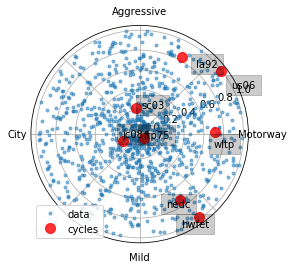

In [8]:
transformed_data   = np.array([transform_to_pc(lrcs_i, pke_i) for lrcs_i, pke_i in zip(log_rcs, pke)])

transformed_cycles = np.array([transform_to_pc(np.log(rcs_i), pke_i) for rcs_i, pke_i in cycles_data])


# distances from mean of the data
distance         = np.sqrt(transformed_data[:,0]**2 + transformed_data[:,1]**2)
cycle_distance   = np.sqrt(transformed_cycles[:,0]**2 + transformed_cycles[:,1]**2)


mean_transformed = np.mean(transformed_data, axis=0) # should be [0,0]
cov_transformed  = np.cov(transformed_data[:,0], transformed_data[:,1]) # Variance should be unchaged but cov =0

ecdf             = ECDF(distance) # Chi2 distribution

# data
ci               = ecdf(distance)
theta            = np.array([(math.atan2(y_i,x_i)) for x_i, y_i in transformed_data])

# cycles
ci_cycles        = ecdf(cycle_distance)
si               = ci_cycles*np.array([math.cos(math.atan2(y_i,x_i)) for x_i, y_i in transformed_cycles])
di               = ci_cycles*np.array([math.sin(math.atan2(y_i,x_i)) for x_i, y_i in transformed_cycles])
theta_cycles     = np.array([(math.atan2(y_i,x_i)) for x_i, y_i in transformed_cycles])


plt.polar(theta, ci, '.', alpha=0.5, label='data')
plt.polar(theta_cycles, ci_cycles, 'or', ms=10, alpha=0.8, label='cycles')
for i, cycle in enumerate(cycle_names):
    plt.text(theta_cycles[i]-0.2, ci_cycles[i], cycle,
            bbox={'facecolor': 'black', 'alpha': 0.2, 'pad': 5})

plt.legend(loc='lower left')
ax = plt.gca()
ax.set_xticklabels(['Motorway', '', 'Aggressive', '', 'City', '', 'Mild', ''])
plt.show()

### Alternate approach to Axes transformations

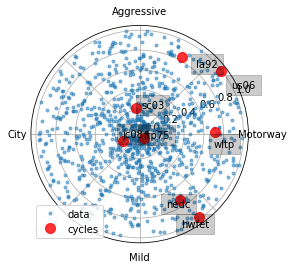

In [9]:
pca = PCA(n_components=2)
X   = np.c_[log_rcs, pke]

transformed_data_pca   = pca.fit_transform(X)
transformed_data       = transformed_data_pca/np.std(transformed_data_pca, axis=0)

transformed_cycles_pca = pca.transform(np.c_[np.log(cycles_data[:,0]), cycles_data[:,1]])
transformed_cycles     = transformed_cycles_pca/np.std(transformed_data_pca, axis=0)

# distances from mean of the data
distance         = np.sqrt(transformed_data[:,0]**2 + transformed_data[:,1]**2)
cycle_distance   = np.sqrt(transformed_cycles[:,0]**2 + transformed_cycles[:,1]**2)

mean_transformed = np.mean(transformed_data, axis=0) # should be [0,0]
cov_transformed  = np.cov(transformed_data[:,0], transformed_data[:,1]) # Variance should be unchaged but cov=0

ecdf             = ECDF(distance) # Chi2 distribution

# data
ci               = ecdf(distance)
theta            = np.array([(math.atan2(y_i,x_i)) for x_i, y_i in transformed_data])

# cycles
ci_cycles        = ecdf(cycle_distance)
si               = ci_cycles*np.array([math.cos(math.atan2(y_i,x_i)) for x_i, y_i in transformed_cycles])
di               = ci_cycles*np.array([math.sin(math.atan2(y_i,x_i)) for x_i, y_i in transformed_cycles])
theta_cycles     = np.array([(math.atan2(y_i,x_i)) for x_i, y_i in transformed_cycles])

plt.polar(theta, ci, '.', alpha=0.5, label='data')
plt.polar(theta_cycles, ci_cycles, 'or', ms=10, alpha=0.8, label='cycles')
for i, cycle in enumerate(cycle_names):
    plt.text(theta_cycles[i]-0.2, ci_cycles[i], cycle,
            bbox={'facecolor': 'black', 'alpha': 0.2, 'pad': 5})

plt.legend(loc='lower left')
ax = plt.gca()
ax.set_xticklabels(['Motorway', '', 'Aggressive', '', 'City', '', 'Mild', ''])
plt.show()